<a href="https://colab.research.google.com/github/smart-stats/ds4bio_book/blob/main/book/linearSeparable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/smart-stats/ds4bio_book/HEAD)


# Linear separable models

We've now covered two ways to do prediction with a single variable, classification using logistic regression and prediction using a line and least squares. What if we have several predictiors? 

In both the logistic and linear regression models, we had a linear predictor, specifically, 

$$
\eta_i = \beta_0 + \beta_1 x_i.
$$

In the continuous case, we were modeling the expected value of the outcomes as linear. In the binary case, we were assuming that the naturual logarithm of the odds of a 1 outcome was linear. 

To estimate the unknown parameters, $\beta_0$ and $\beta_1$ we minimized

$$
\sum_{i=1}^n || y_i - \eta_i||^2 
$$

in the linear case and 

$$
-\sum_{i=1}^n \left[
  Y_i \eta_i + \log\left\{\frac{1}{1 + e^{\eta_i}} \right\} \right].
$$

in the binary outcome case (where, recall, $\eta_i$ depends on the parameters).  We can easily extend these models to multiple predictors by assuming that the impact of the multiple predictors is linear and separable. That is,

$$
\eta_i = \beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} + \ldots \beta_{p-1} x_{p-1,i}
$$

If we think about this as vectors and matrices, we obtain

$$
\eta = X \beta
$$

where $\eta$ is an $n \times 1$ vector, $X$ is an $n \times p$ matrix with $i,j$ entry $x_{ij}$ and $\beta$ is a $p\times 1$ vector with entries $\beta_j$. 


Let's look at the voxel-level data that we've been working with. First let's load the data.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
import sklearn as skl
import statsmodels.formula.api as smf
import statsmodels as sm

## this sets some style parameters  
sns.set()

## Read in the data 
dat = pd.read_csv("https://raw.githubusercontent.com/bcaffo/ds4bme_intro/master/data/oasis.csv")


Let's first try to fit the proton density data from the other imaging data. I'm going to use the `statsmodels` version of linear models since it has a nice format for dataframes.

In [2]:
trainFraction = .75

sample = np.random.uniform(size = 100) < trainFraction
trainingDat = dat[sample]
testingDat = dat[~sample]

In [3]:
results = smf.ols('PD ~ FLAIR + T1 + T2  + FLAIR_10 + T1_10 + T2_10 + FLAIR_20', data = trainingDat).fit()
print(results.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.708   
Dependent Variable: PD               AIC:                76.9379 
Date:               2024-01-21 22:39 BIC:                95.4778 
No. Observations:   75               Log-Likelihood:     -30.469 
Df Model:           7                F-statistic:        26.60   
Df Residuals:       67               Prob (F-statistic): 4.78e-17
R-squared:          0.735            Scale:              0.14770 
------------------------------------------------------------------
                Coef.   Std.Err.     t     P>|t|    [0.025  0.975]
------------------------------------------------------------------
Intercept       0.2980    0.1539   1.9369  0.0570  -0.0091  0.6051
FLAIR          -0.0159    0.0958  -0.1660  0.8687  -0.2071  0.1753
T1             -0.1644    0.0866  -1.8978  0.0620  -0.3373  0.0085
T2              0.6195    0.0866   7.1525  0.0000   0.4467  0.7924
FLAIR_10       -0.61

In [4]:
x = dat[['FLAIR','T1', 'T2', 'FLAIR_10', 'T1_10', 'T2_10', 'FLAIR_20']]
y = dat[['GOLD_Lesions']]
## Add the intercept column
x = sm.tools.add_constant(x)

xtraining = x[sample]
xtesting = x[~sample]
ytraining = y[sample]
ytesting = y[~sample]


In [5]:
fit = sm.discrete.discrete_model.Logit(ytraining, xtraining).fit()

Optimization terminated successfully.
         Current function value: 0.134297
         Iterations 11


In [6]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           GOLD_Lesions   No. Observations:                   75
Model:                          Logit   Df Residuals:                       67
Method:                           MLE   Df Model:                            7
Date:                Sun, 21 Jan 2024   Pseudo R-squ.:                  0.8062
Time:                        22:39:44   Log-Likelihood:                -10.072
converged:                       True   LL-Null:                       -51.979
Covariance Type:            nonrobust   LLR p-value:                 2.292e-15
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.3155      5.843     -2.108      0.035     -23.767      -0.864
FLAIR          4.1918      1.938      2.163      0.031       0.394       7.989
T1             2.0904      1.406      1.487      0.137      -0.665       4.845
T2             0.9518      1.337      0.712      0.477      -1.669       3.573
FLAIR_10      28.4077     13.640      2.083      0.037       1.673      55.142
T1_10          7.7530      4.367      1.775      0.076      -0.806      16.312
T2_10        -20.8353     11.802     -1.765      0.077     -43.966       2.296
FLAIR_20     -32.7591     16.165     -2.027      0.043     -64.442      -1.076
==============================================================================

Possibly complete quasi-separation: A fraction 0.29 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Now let's evaluate our prediction. Here, we're not going to classify as 0 or 1, but rather estimate the prediction. Note, we then would need to pick a threshold to have a classifier. We could use .5 as our threshold. However, it's often the case that we don't necessarily want to threshold at specifically that level. A solution for evalution is to plot how the sensitivity and specificity change by the threshold. 

In other words, consider the triplets
$$
(t, sens(t), spec(t))
$$
where $t$ is the threshold, `sens(t)` is the sensitivity at threshold $t$, `spec(t)` is the specificity at threshold `t`. 

Necessarily, the sensitivity and specificity 



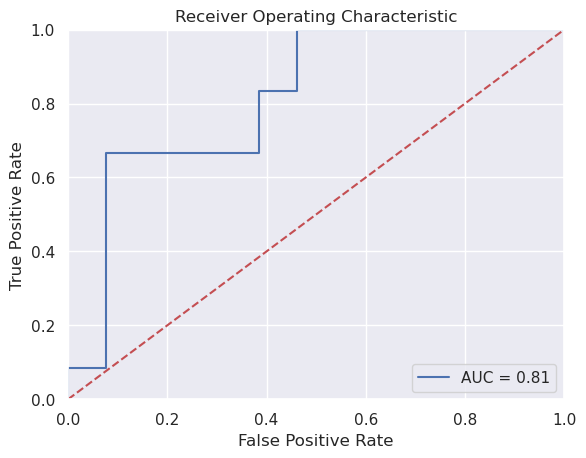

In [7]:
phatTesting = fit.predict(xtesting)

## See here for plotting
## https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
fpr, tpr, threshold = skl.metrics.roc_curve(ytesting, phatTesting)
roc_auc = skl.metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


## Aside different python packages

So far we've explored several plotting libraries including: default pandas methods, matplotlib, seaborn and plotly. We've also looked at several fitting libraries including to some extent numpy, but especially scikitlearn and statsmodels. What's the difference? Well, these packages are all mantained by different people and have different features and goals. For example, scikitlearn is more expansive than statsmodels, but statsmodels functions more like one is used to with statistical output. Matplotlib is very expansive, but seaborn has nicer default options and is a little easier. So, when doing data science with python, one has to get used to trying out a few packages, weighing the cost and benefits of each, and picking one. 

'statsmodels', what we're using above, has multiple methods for fitting binary models including: `sm.Logit`, `smf.logit`, `BinaryModel` and `glm`. Here I'm just going to use `Logit` which does not use the formula syntax of `logit`. Note, by default, this does not add an intercept this way. So, I'm adding a column of ones, which adds an intercept.

Consider the following which uses the formula API


In [8]:
results = smf.logit(formula = 'GOLD_Lesions ~ FLAIR + T1 + T2 + FLAIR_10 + T1_10 + T2_10 + FLAIR_20', data = trainingDat).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.134297
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           GOLD_Lesions   No. Observations:                   75
Model:                          Logit   Df Residuals:                       67
Method:                           MLE   Df Model:                            7
Date:                Sun, 21 Jan 2024   Pseudo R-squ.:                  0.8062
Time:                        22:39:44   Log-Likelihood:                -10.072
converged:                       True   LL-Null:                       -51.979
Covariance Type:            nonrobust   LLR p-value:                 2.292e-15
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -12.3155      5.843     -2.108      0.035     -23.767      -0.864
FLAIR          4.1918      1.938      2.163      0.031       0.394       7.989
T1             2.0904      1.406      1.487      0.137      -0.665       4.845
T2             0.9518      1.337      0.712      0.477      -1.669       3.573
FLAIR_10      28.4077     13.640      2.083      0.037       1.673      55.142
T1_10          7.7530      4.367      1.775      0.076      -0.806      16.312
T2_10        -20.8353     11.802     -1.765      0.077     -43.966       2.296
FLAIR_20     -32.7591     16.165     -2.027      0.043     -64.442      -1.076
==============================================================================

Possibly complete quasi-separation: A fraction 0.29 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""